In [1]:
import numpy as np
import pandas as pd
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

import utils.other
import utils.spectral
from pyaw import utils
from pyaw.swarm import rotate_vector_by_quaternion

In [2]:
fps = ['./SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './aux_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './IGRF_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './SW_EXPT_EFIA_TCT16_12885_20160311T061733_20160311T075106.pkl']

In [3]:
df_b = pd.read_pickle(fps[0])
# df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

In [4]:
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius','q_NEC_CRF']]
# df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]

In [5]:
st = '20160311T064000'
et = '20160311T065000'
df_b_clip = df_b_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
# df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_e_clip = df_e_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

np.all(np.equal(df_b_clip.index.values,df_b_IGRF_clip.index.values))

True

In [6]:
ehx = df_e_clip['Ehx'].values

In [7]:
ehx = utils.set_outliers_nan_std(ehx,1,print_=False)
ehx = utils.get_array_interpolated(df_e_clip.index.values,ehx)

In [8]:
from pyaw.core.preprocess_data import SwarmPreprocess

b_nec2sc = SwarmPreprocess.MagPreprocess.NEC2SCofMAG(df_b_clip['B_NEC'].values, df_b_clip['q_NEC_CRF'].values)
b_sc = b_nec2sc.calculate_rotated_vectors()

b_igrf_nec2sc = SwarmPreprocess.MagPreprocess.NEC2SCofMAG(df_b_IGRF_clip['B_NEC_IGRF'].values, df_b_clip['q_NEC_CRF'].values)
b_igrf_sc = b_igrf_nec2sc.calculate_rotated_vectors()

by1 = b_sc[:,1] - b_igrf_sc[:,1]

In [9]:
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values

by1 = utils.data.align_high2low(by1, datetimes_b, datetimes_e)

# fft

In [10]:
fs=16
ehx_fft = utils.spectral.FFT(ehx, fs)
by1_fft = utils.spectral.FFT(by1, fs)

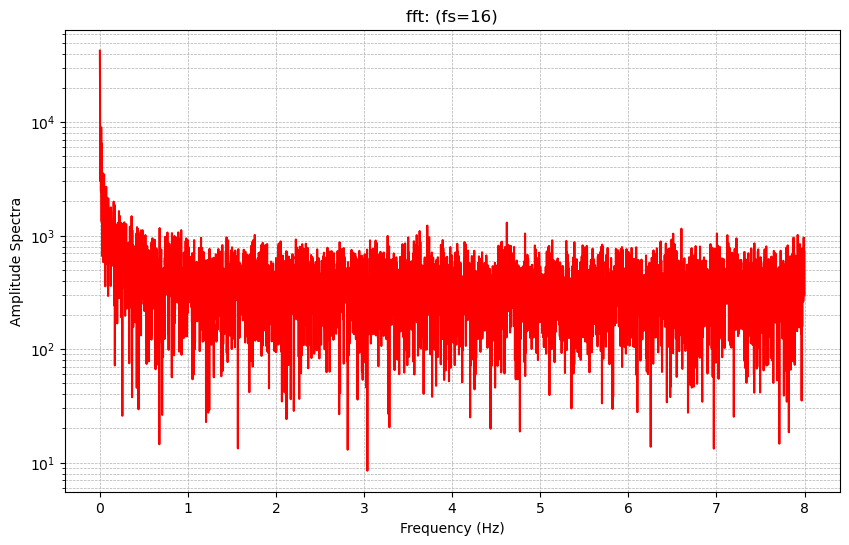

In [11]:
ehx_fft.plot_fft()
plt.show()

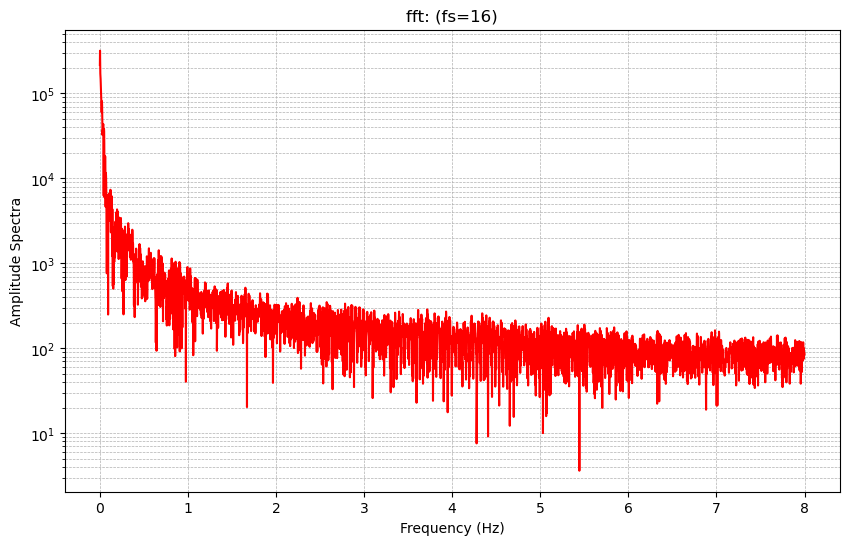

In [12]:
by1_fft.plot_fft()
plt.show()

In [13]:
freqs, amp_e, _ = ehx_fft.get_fft()
_, amp_b, _ = by1_fft.get_fft()

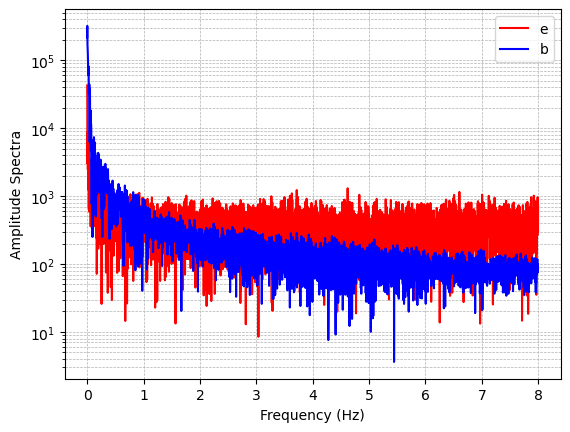

In [14]:
plt.plot(freqs, amp_e, color='red', label='e')
plt.plot(freqs, amp_b, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [15]:
eb_ratio_fft = amp_e / amp_b
eb_ratio_fft = eb_ratio_fft * 1e-3 * 1e9

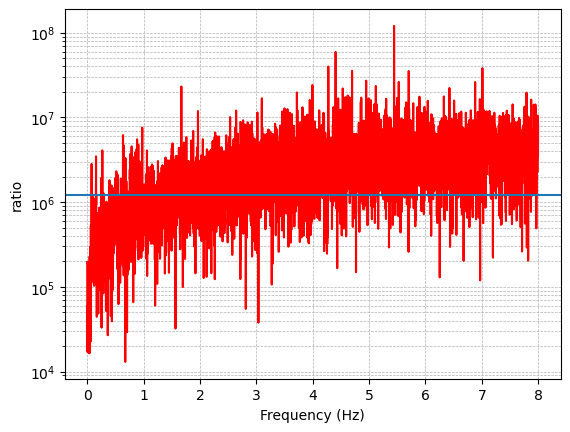

In [16]:
plt.plot(freqs, eb_ratio_fft, color='red', label='e')
plt.axhline(1.2e6)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

# cpsd

In [17]:
window = 'hann'
spectrogram_window_seconds = 4
nperseg = int(spectrogram_window_seconds * fs)
noverlap = nperseg // 2

freqs, ts, Sxx_e = spectrogram(ehx, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')
_, _, Sxx_b = spectrogram(by1, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64 = datetimes_e[0] + [np.timedelta64(int(_), 's') for _ in ts]

In [18]:
cpsd = Sxx_e * np.conj(Sxx_b)
cpsd_m = np.abs(cpsd)
cpsd_p = np.degrees(np.angle(cpsd))

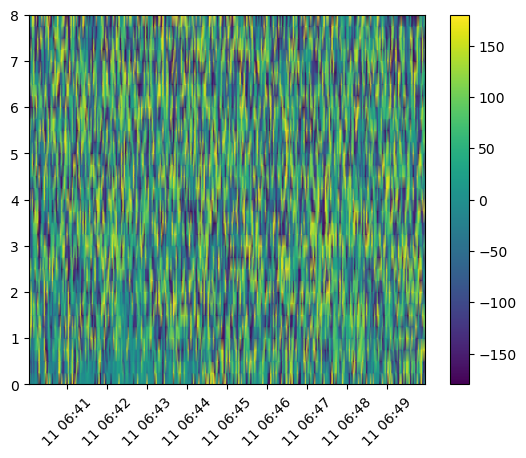

In [19]:
plt.pcolormesh(ts_dt64, freqs, cpsd_p, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [20]:
np.max(cpsd_m),np.min(cpsd_m),np.percentile(cpsd_m, 50)

(103.86020605611601, 2.4361152254424467e-06, 0.014459608151262985)

In [21]:
cpsd_p_mask = cpsd_p.copy()
cpsd_p_mask[cpsd_m < 0.003] = np.nan

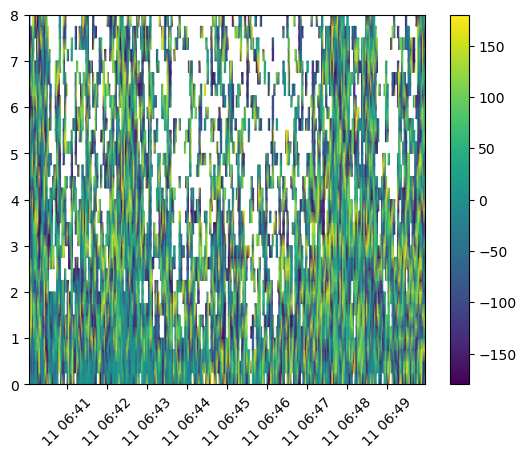

In [22]:
plt.pcolormesh(ts_dt64, freqs, cpsd_p_mask, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [23]:
num_bins = 50
phase_bins, phase_histogram2d = utils.get_phase_histogram2d(freqs,cpsd_p_mask,num_bins=num_bins)

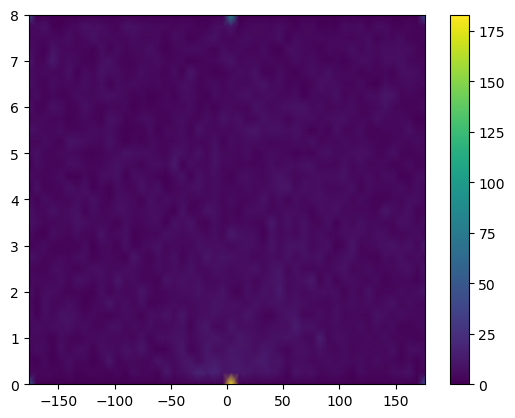

In [24]:
plt.pcolormesh((phase_bins[:-1] + phase_bins[1:]) / 2, freqs, phase_histogram2d, shading='gouraud')
plt.colorbar()
plt.show()

In [25]:
phases_ave = utils.get_phase_histogram_f_ave(phase_bins, phase_histogram2d)

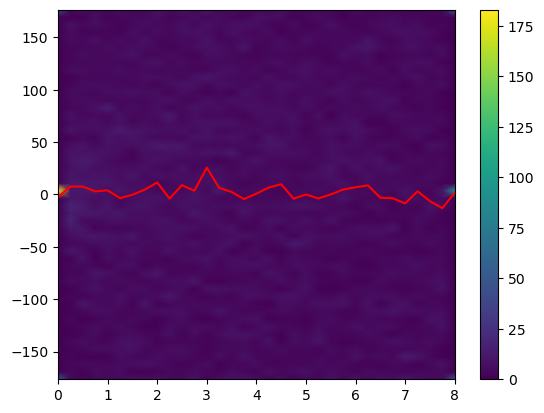

In [26]:
plt.pcolormesh(freqs, (phase_bins[:-1] + phase_bins[1:]) / 2, phase_histogram2d.T, shading='gouraud')
plt.plot(freqs,phases_ave,color='r')
plt.colorbar()
plt.show()

# cwt

In [27]:
import pywt

wavelet = 'cmor1.5-1.0'
num_frequencies = 160
min_freq, max_freq = 1e-3, 16  # Desired frequency range

# Compute uniformly spaced frequencies
freqs = np.linspace(min_freq, max_freq, num_frequencies)

# Compute corresponding scales
central_freq = pywt.central_frequency(wavelet)

scales = central_freq / (freqs * (1 / fs))

In [28]:
cwt_eb = utils.spectral.CWT(ehx, by1, scales=scales, fs=fs)
cwt_eb_m, cwt_eb_p, cwt_eb_f = cwt_eb.get_cross_spectral()

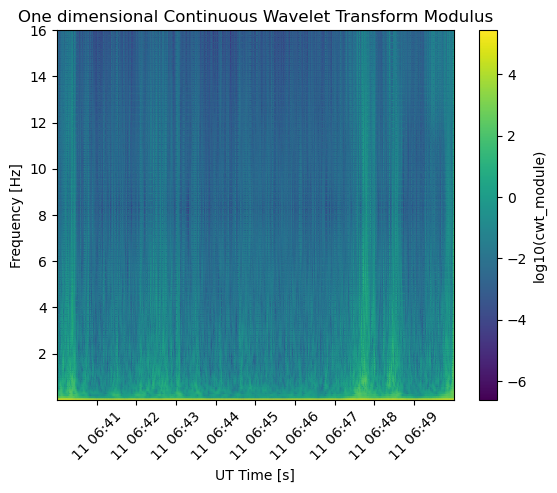

In [29]:
plt.pcolormesh(datetimes_e,cwt_eb_f,np.log10(cwt_eb_m),shading='gouraud')
plt.colorbar(label='log10(cwt_module)')
plt.xticks(rotation=45)
plt.xlabel('UT Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('One dimensional Continuous Wavelet Transform Modulus')
plt.show()

In [30]:
num_bins = 50
cwt_eb_p_bins, cwt_eb_p_histogram2d = utils.get_phase_histogram2d(cwt_eb_f, cwt_eb_p, num_bins)

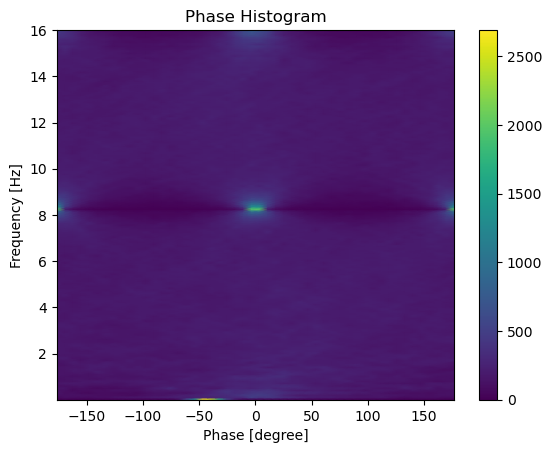

In [31]:
plt.pcolormesh((cwt_eb_p_bins[:-1] + cwt_eb_p_bins[1:]) / 2, cwt_eb_f, cwt_eb_p_histogram2d, shading='gouraud')
plt.colorbar()
plt.xlabel('Phase [degree]')
plt.ylabel('Frequency [Hz]')
plt.title('Phase Histogram')
plt.show()  # 中间的亮斑和带状形成的原因？

In [32]:
cwt_p_ave = utils.get_phase_histogram_f_ave(cwt_eb_p_bins,cwt_eb_p_histogram2d)

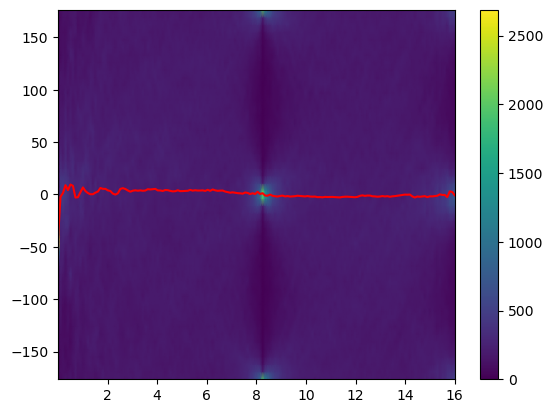

In [33]:
plt.pcolormesh(cwt_eb_f, (cwt_eb_p_bins[:-1] + cwt_eb_p_bins[1:]) / 2, cwt_eb_p_histogram2d.T, shading='gouraud')
plt.plot(cwt_eb_f,cwt_p_ave,color='r')
plt.colorbar()
plt.show()